In [134]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *
import tmv_app
import tmv_app.utils.plotting as tplots
from tmv_app.utils.plotting import SquareCollection, CoordSquare

### We start by loading up a model and calculating/loading the tsne positions of its documents

In [135]:
run_id = 2574
stat = RunStats.objects.get(pk=run_id)
q = stat.query

# position the papers in a 2-dimensional topic space, with perplexity p
# unless you pass the argument force_overwrite=True, the results are not recalculated
s = 0
p = 100
tsne_results, r_ind = stat.calculate_tsne('tsne_results/data', p)

We've already calculated the required matrices!
We've already calculated the tsne positions


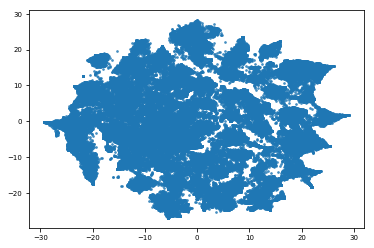

In [136]:
plt.scatter(tsne_results[:,0],tsne_results[:,1], s=3, alpha=0.7)

### We have a cloud of dots! Now we can colour by the dots' properties



In [158]:
r_ind

array([1966080, 1966081, 1966082, ..., 1966068, 1966069, 1966070],
      dtype=object)

In [167]:
query_map = [
    ("All Sources","grey",[6305,6299,7947]),
    ("Survey+Chapter","#bebada",[6305,6299]),
    ("Survey+Additional","#8dd3c7",[7947,6299]), # green
    ("Chapter+Additional","#fdb462",[7947,6305]), # orange
    #("Chapter","#fb8072",[6305]), # red
    ("Chapter","#ffffb3",[6305]), # yellow
    #("Survey","#80b1d3",[6299]), # blue
    ("Survey","#fb8072",[6299]), # red
    #("Additional","#ffffb3",[7947]), # yellow
    ("Additional","#ffffb3",[7947]), # yellow
]

q_cats = []
all_ids = set([])
for x in query_map:
    print(x[0])
    dids = set([])
    for i, qid in enumerate(x[2]):
        q = Query.objects.get(pk=qid)
        qds = set(q.doc_set.values_list('pk',flat=True))
        if i==0:
            dids = qds
        else:
            dids = dids & qds
            
    dids = dids - all_ids
    all_ids = all_ids | dids
    c = {
        "name": x[0],
        "color": x[1],
        "docs": list(dids & set(r_ind)),
        "dis": np.argwhere(np.isin(r_ind,list(dids & set(r_ind)))),

    }
    print(f"docs: {len(c['docs'])}")
    q_cats.append(c)
    

All Sources
docs: 2390
Survey+Chapter
docs: 20690
Survey+Additional
docs: 1010
Chapter+Additional
docs: 5255
Chapter
docs: 41714
Survey
docs: 11400
Additional
docs: 0


calculating points took 0.705s.


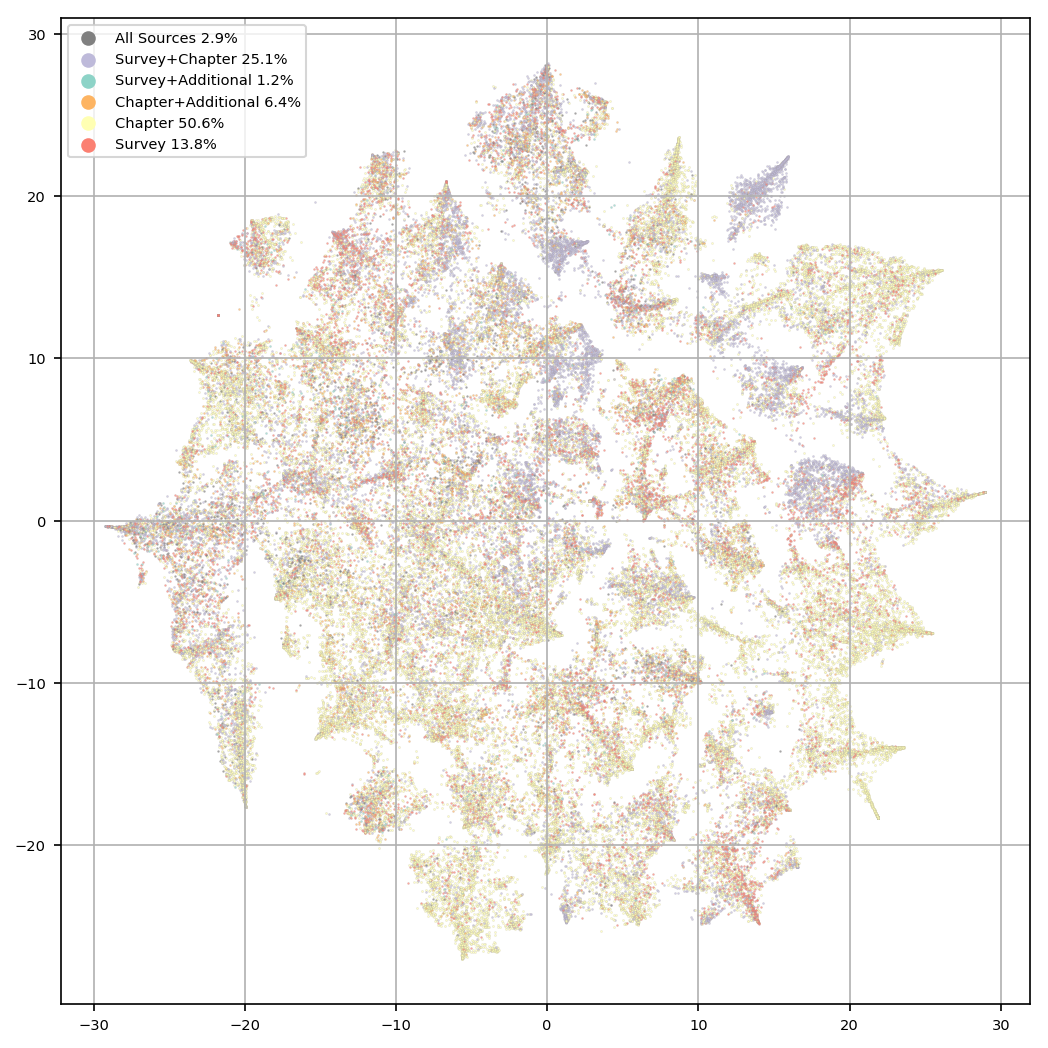

In [171]:
# Produce one plot first and summarise the squares
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tplots.plot_tsne(r_ind,tsne_results,q_cats,[],verbose=True,ax=ax)

fig.tight_layout()


calculating points took 0.466s.


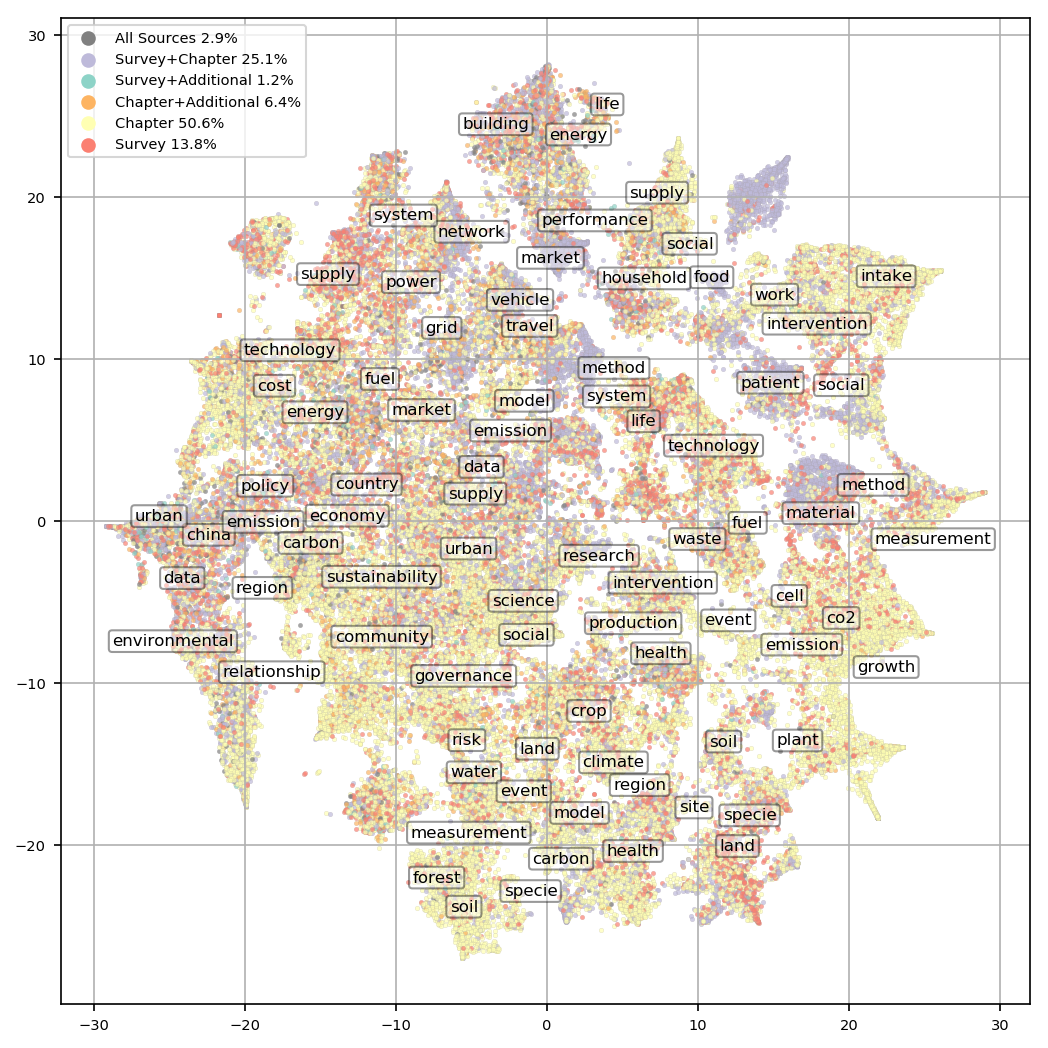

In [173]:
# Produce one plot first and summarise the squares
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

tops = Topic.objects.filter(
    run_id=run_id,
    share__gt=0.01 # Only include the larger topics, to prevent the map getting too full of labels
)

fig, ax = plt.subplots( figsize=(7,7), dpi=150)

tplots.plot_tsne(
    r_ind,
    tsne_results,
    q_cats,
    [],
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops,
    t_thresh=0.98,
    eps=5, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    words_only=True
)

fig.tight_layout()


In [4]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats = sorted(oecd_cats, key=itemgetter('n_docs'), reverse=True)


calculating points took 0.639s.
[-40. -30. -20. -10.   0.  10.  20.  30.  40.]


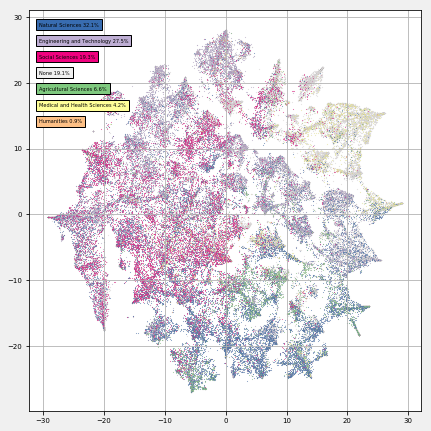

In [5]:
# Produce one plot first and summarise the squares
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

fig, ax = plt.subplots( figsize=(6,6))
tplots.plot_tsne(r_ind,tsne_results,oecd_cats,no_oecd_ids,verbose=True,ax=ax)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()
for extension in ["png","svg"]:
    plt.savefig(
        f'plots/tsne_results/run_{run_id}_s_{s}_p{p}_oecds.{extension}',
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )

sc = SquareCollection()   
xs = plt.xticks()[0]
ys = plt.yticks()[0]

print(xs)

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys)-1:
            break
        y2 = ys[j+1]

        cs = CoordSquare(x1,x2,y1,y2,r_ind,tsne_results,0)
        cs.get_points()
        sc.add(cs)
    
plt.show()

### Hm, it seems like we have no disciplinary information for many of the documents - perhaps that could be something to do with how they were imported?

The number below shows the number of documents with missing information in the web of science category field (N.B. many of the documents will already have been in the database, so might already have that field populated)

In [6]:
print(q.id)
Doc.objects.filter(query=q,wosarticle__wc__isnull=True).count()

7360


16156

## Here we put topic labels where there are clusters of documents related to a topic

calculating points took 0.466s.


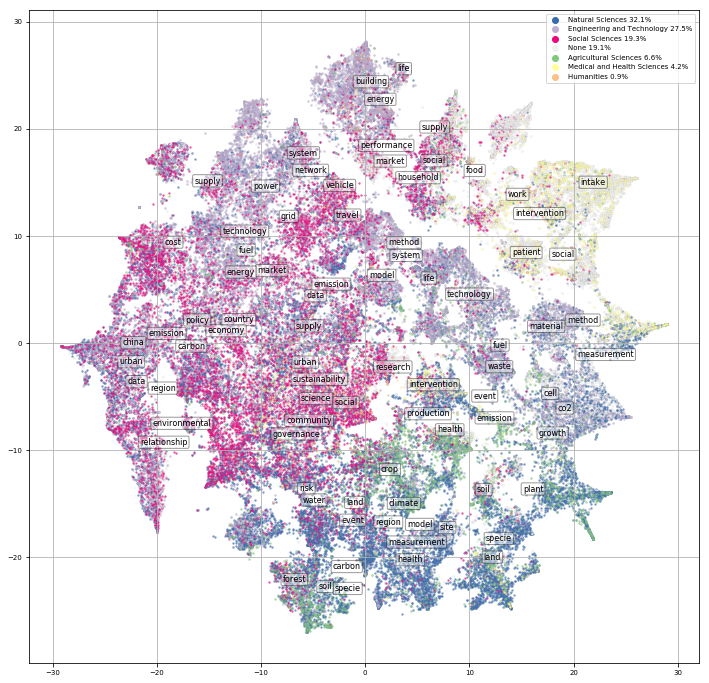

In [7]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tops = Topic.objects.filter(
    run_id=run_id,
    share__gt=0.01 # Only include the larger topics, to prevent the map getting too full of labels
)


fig, ax = plt.subplots( figsize=(7,7),dpi=150)
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    topics=tops,
    t_thresh=0.98,
    eps=5, # Input for clustering, higher values allow larger distances between docs 
    draw_highlight_points=False,
    adjust=True,
    dot_legend=True,
    words_only=True
)

#fig.patch.set_facecolor('#f0f0f0') 

plt.show()

## Now we label clusters of documents belonging to each of the queries

In [174]:
short_name_dict = {
    "Sufficiency and distributional analyses in the demand side of climate change mitigation":"Sufficiency",
    "Determinants of low-carbon transport mode adoption: Systematic review of reviews": "Transport",
    "Status consciousness in energy consumption decisions: A systematic review of literature": "Status",
    "Exploring SDG links of dietary choice and food waste related mitigation solutions-II": "SDG Diets II",
    "Well-being/demand side search query": "Well-being",
    "Well-being, demand side search query": "Well-being",
    "Systematic Review of Case Studies on Demand Side Climate Mitigation Actions through Local Urban Governance in Developing Countries":"Urban Governance",
    "Shared Mobility: A Systematic Review of its Impacts": "Shared Mobility",
    "Working time reduction in climate change mitigation (same paper, diff query)":"Working Time",
    "Working time reduction in climate change mitigation": "Working Time II",
    "Integrating Indigenous Knowledge Systems into climate change adaptation strategies for sustainable development": "Indigenous Knowledge",
    "Dematerialisation and sharing of goods: a systematic review of the determinants and magnitude of the indirect impacts on energy consumption":"Dematerialising & Sharing",
    "Mitigating climate change in food consumption and food waste: A systematic map of behavioural interventions": "Food Behaviour",
    "Disruptive consumer innovations for climate change": "Disruptive Innovations",
    "Exploring SDG links of dietary choice and food waste related mitigation solutions": "SDG Diets",
    "A literature survey on demand-side solutions for climate-change mitigation": "Literature Survey",
    "A literature survey on demand-side solutions for climate-change mitigation (2)": "Literature Survey (2)",
    "Urban energy demand in global south cities": "Global South Cities",
    "A Systematic Review for The Equity of Health Burdens Caused by Climate Change": "Health Equity",
    "Drivers for Behavioural Change": "Behavioural Drivers",
    "The potential for teleworking": "Teleworking",
    "Acceptability for climate solution": "Acceptability",
    "Quantifying the potential for climate change mitigation of consumption-based options": "Quantifying potential",
    "A global map of demand typologies for a low-carbon building sec": "Building Demand Typologies",
    "Bottom-up drivers of household energy behavior changes": "Bottom-up drivers",
    "Bottom-up drivers of household energy behavior changes (2)": "Bottom-up drivers (2)",
}

qs = Query.objects.filter(
    project=147,
    creator__username="java"
).exclude(
    pk__in=[6262,6265,6256,6263,6260,6303,6299,6270]
).order_by('r_count')

# If we assemble a list of dictionaries with the title, and docs (a list of doc ids)
# We can pass this to the doc_sets argument of the plotting function

qdicts = []
for q in qs:
    try:
        qd = {
            'title': short_name_dict[q.title],
            'docs': list(q.doc_set.all().values_list('pk', flat=True))
        }
        qdicts.append(qd)
    except:
        pass

calculating points took 0.508s.


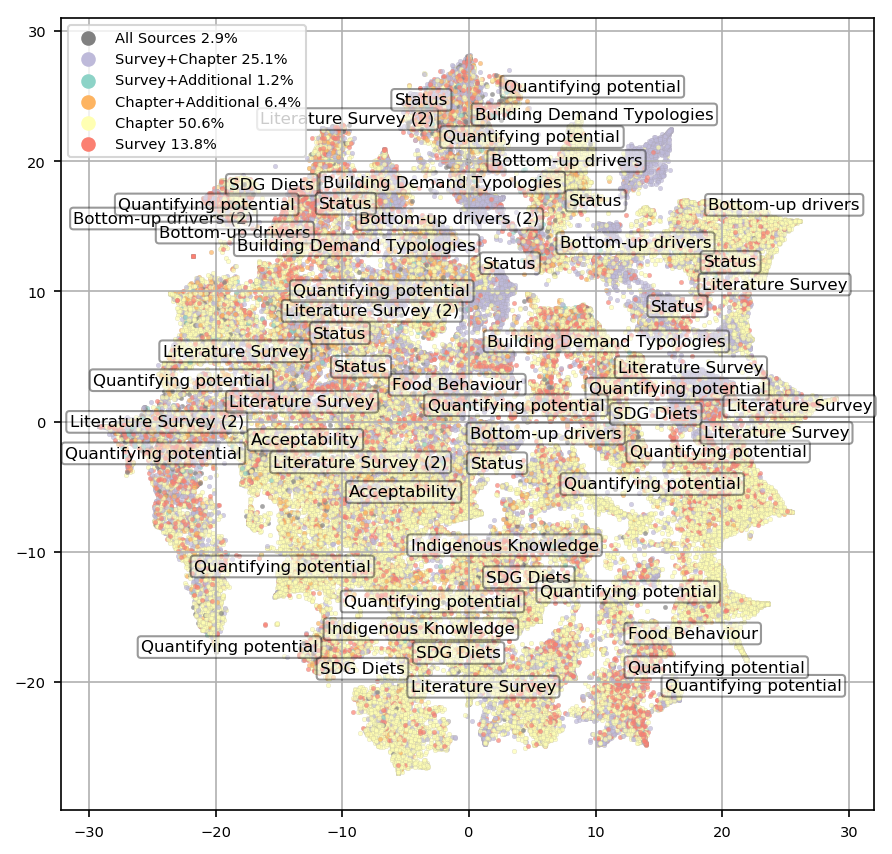

In [175]:


fig, ax = plt.subplots( figsize=(7,7), dpi=150)
tplots.plot_tsne(
    r_ind,
    tsne_results,
    q_cats,
    [],
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    doc_sets=qdicts,
    t_thresh=0.8,
    words_only=True,
    adjust=True,
    eps=2, # Input for clustering, higher values allow larger distances between docs 
    min_cluster=50,
    dot_legend=True,
)

plt.show()

calculating points took 0.454s.


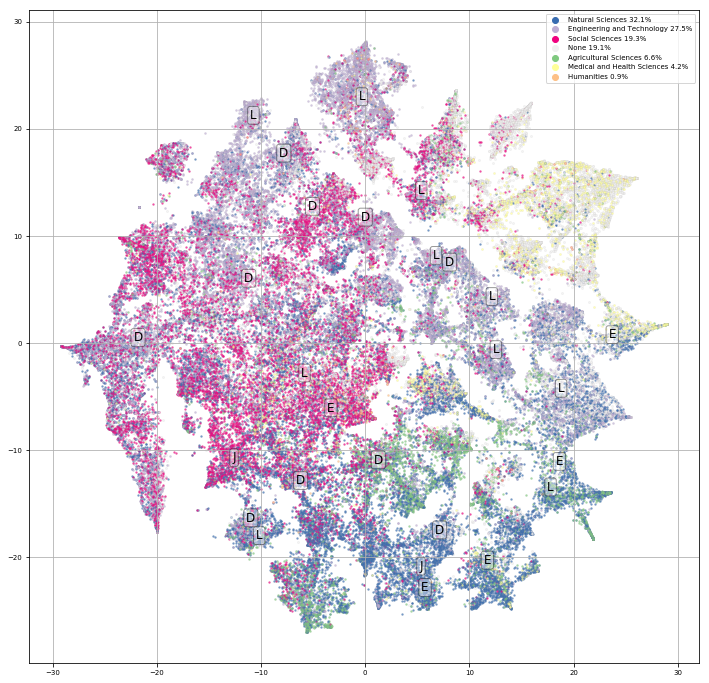

In [130]:
import importlib
importlib.reload(tmv_app.utils.plotting)

p2 = Project.objects.get(pk=148)
qs2 = p2.query_set.filter(
    database="WoS",title__iregex="^Query [A-Z]_renew",
    creator__username="java"
).order_by('title')

qdicts_2 = []
for q in qs2:
    qd = {
        'title': q.title.replace('query ','').replace('Query ','')[:1],
        'docs': list(q.doc_set.all().values_list('pk', flat=True))
    }
    qdicts_2.append(qd)
    
fig, ax = plt.subplots( figsize=(7,7), dpi=150)
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    doc_sets=qdicts_2,
    t_thresh=0.8,
    words_only=True,
    adjust=True,
    eps=2, # Input for clustering, higher values allow larger distances between docs 
    min_cluster=50, # The minimum number of docs in a cluster
    clabel_size=12, # We can play with the label size of the cluster labels here
    dot_legend=True,
)



plt.show()

calculating points took 0.489s.


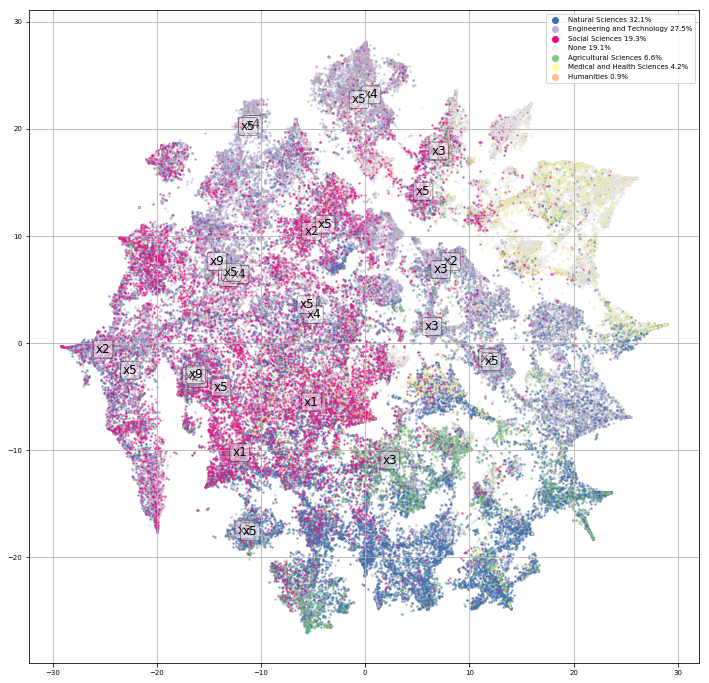

In [131]:
import importlib
importlib.reload(tmv_app.utils.plotting)

p3 = Project.objects.get(pk=210)
qs3 = p3.query_set.filter(
    database="WoS",creator__username="java"
).order_by('title')

qdicts_3 = []
for q in qs3:
    qd = {
        'title': q.title,
        'docs': list(q.doc_set.all().values_list('pk', flat=True))
    }
    qdicts_3.append(qd)
    
fig, ax = plt.subplots( figsize=(12,12))
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    doc_sets=qdicts_3,
    words_only=True,
    t_thresh=0.8,
    eps=2, # Input for clustering, higher values allow larger distances between docs 
    min_cluster=50, # The minimum number of docs in a cluster
    clabel_size=12, # We can play with the label size of the cluster labels here
    dot_legend=True,
)

#fig.patch.set_facecolor('#f0f0f0') 

plt.show()

In [132]:
## If we set `words_only` to `False` we can also draw smoothed convex hulls around the clusters of documents

calculating points took 0.508s.


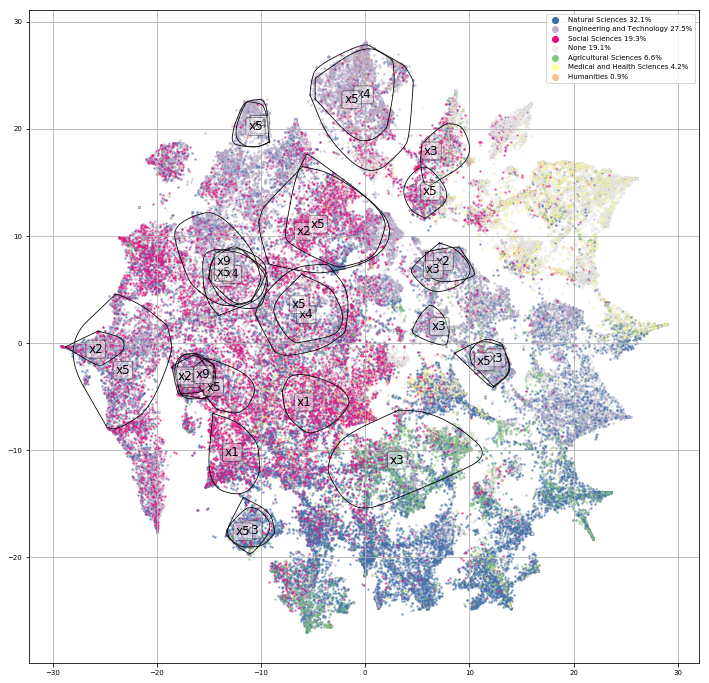

In [128]:
import importlib
importlib.reload(tmv_app.utils.plotting)

p3 = Project.objects.get(pk=210)
qs3 = p3.query_set.filter(
    database="WoS",creator__username="java"
).order_by('title')

qdicts_3 = []
for q in qs3:
    qd = {
        'title': q.title,
        'docs': list(q.doc_set.all().values_list('pk', flat=True))
    }
    qdicts_3.append(qd)
    
fig, ax = plt.subplots( figsize=(12,12))
tplots.plot_tsne(
    r_ind,
    tsne_results,
    oecd_cats,
    no_oecd_ids,
    verbose=True,
    ax=ax,
    psize=5, #pointsize
    doc_sets=qdicts_3,
    t_thresh=0.8,
    words_only=False,
    eps=2, # Input for clustering, higher values allow larger distances between docs 
    min_cluster=50, # The minimum number of docs in a cluster
    clabel_size=12, # We can play with the label size of the cluster labels here
    dot_legend=True,
)

#fig.patch.set_facecolor('#f0f0f0') 

plt.show()

### Now we'll try and put these in the topic space of the big climate change query

Those documents that are in both are highlighted

calculating points took 1.333s.


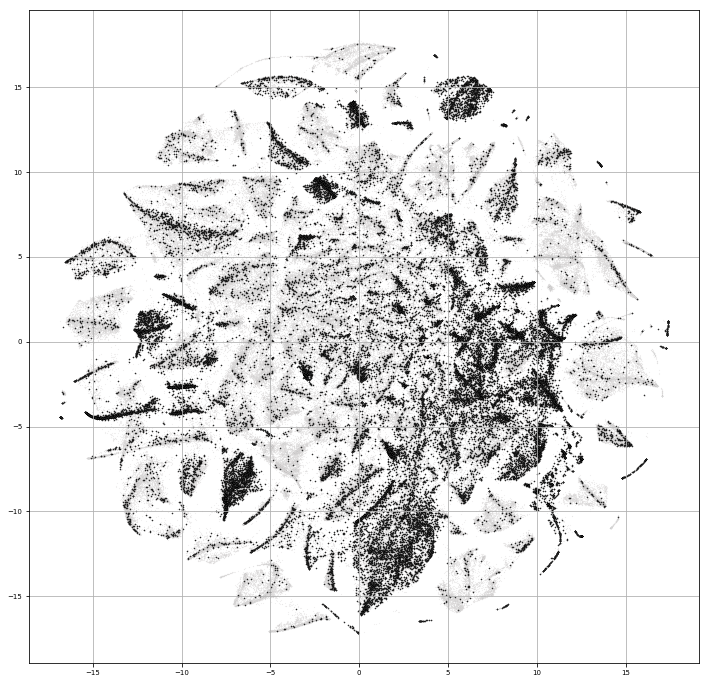

In [12]:
r_ind_cc = np.load('/home/galm/projects/cc-topography/tsne_results/data/run_1861_s_0_r_ind.npy')
tsne_results_cc = np.load('/home/galm/projects/cc-topography/tsne_results/data/run_1861_s_0_p50.npy')

qdocs = Doc.objects.filter(query=stat.query).values_list('pk',flat=True)

highlight_docs = np.argwhere(np.isin(r_ind_cc,qdocs))

fig, ax = plt.subplots( figsize=(12,12))

tmv_app.utils.plotting.plot_tsne(
    r_ind_cc,tsne_results_cc, [],
    r_ind_cc, ax=ax,
    verbose=True, hdoc=highlight_docs
)

plt.show()

In [13]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids_cc = r_ind_cc
stat_cc = RunStats.objects.get(pk=1861)
q_cc = stat_cc.query

oecd_cats_cc = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats_cc):
    ds = Doc.objects.filter(query=q_cc,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind_cc))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind_cc,c['docs']))
    no_oecd_ids_cc = no_oecd_ids_cc[np.isin(no_oecd_ids_cc,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats_cc = sorted(oecd_cats_cc, key=itemgetter('n_docs'), reverse=True)

calculating points took 1.974s.


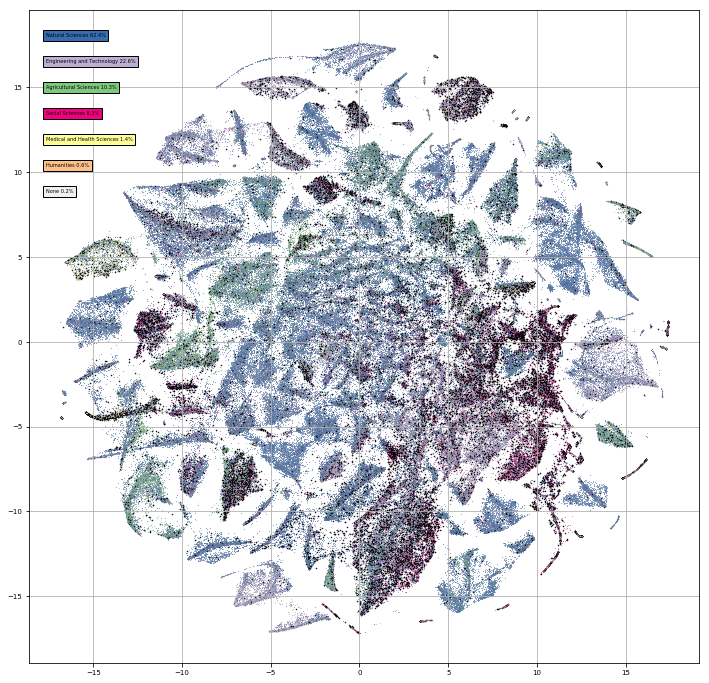

In [14]:
import importlib
importlib.reload(tmv_app.utils.plotting)

fig, ax = plt.subplots( figsize=(12,12))

tmv_app.utils.plotting.plot_tsne(
    r_ind_cc,tsne_results_cc, oecd_cats_cc,
    no_oecd_ids_cc, ax=ax,
    verbose=True, hdoc=highlight_docs
)

plt.show()